In [126]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision as tv
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import glob
from PIL import Image
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化

In [30]:
class STLDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""

    def __init__(self, df, transform=None):
        self.file_paths = df.img.values
        self.labels = df.y.values
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        file_path = self.file_paths[idx]
        image = Image.open(file_path)

        if self.transform:
            image = self.transform(image)

        return image, label, file_path

In [22]:
root_path = '.\\input\\train\\'

df_train = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_train['img'] = [f for f in files]
df_train['y'] = [int(f.split('\\')[-2]) for f in df_train.img]

In [33]:
root_path = '.\\input\\test\\'

df_test = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_test['img'] = [f for f in files]
df_test['y'] = [int(f.split('\\')[-2]) for f in df_test.img]

classes = ('airplane', 'bird', 'car', 'cat','deer', 
           'dog', 'horse', 'monkey', 'ship', 'truck')

In [132]:
train_transform = transforms.Compose([
    # transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.45),
    transforms.RandomVerticalFlip(p=0.45),
    # transforms.RandomGrayscale(p=0.15),
    # transforms.ColorJitter(brightness=0.8, contrast=1.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

test_transform = transforms.Compose([
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [43]:
num_workers = 0
batch_size = 32

train_dataset = STLDataset(df_train, transform=train_transform)
valid_dataset = STLDataset(df_test, transform=test_transform)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        cat        deer         cat       truck


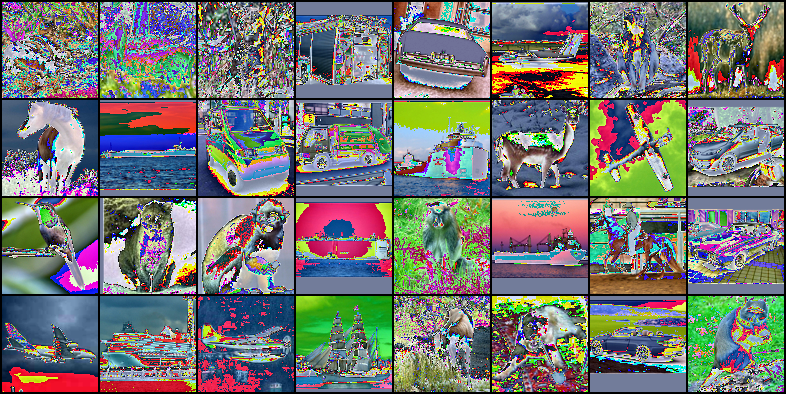

In [44]:
dataiter = iter(trainloader)
images, labels, _ = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'% classes[labels[j]-1] for j in range(4)))
show(tv.utils.make_grid((images+1)/2))

In [136]:
model = tv.models.vgg16_bn(pretrained='ImageNet')
model.classifier = nn.Sequential(
    nn.Linear(in_features=4608, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=10, bias=True),
  )
model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\root/.torch\models\vgg16_bn-6c64b313.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 553507836/553507836 [02:02<00:00, 4519759.40it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [61]:
def train(net, epoch):

    net.train()
    
    losses = 0
    for batch_index, (images, labels, _) in enumerate(trainloader):

        images = Variable(images)
        labels = Variable(labels)

        labels = labels.cuda()
        images = images.cuda()

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        trained_samples = batch_index * batch_size + len(images)
        losses += loss.item()
    
    print('Training Epoch: {epoch} [{trained_samples}/{total_samples}]\tLoss: {:0.4f}\tLR: {:0.6f}'.format(
                losses / trained_samples,
                optimizer.param_groups[0]['lr'],
                epoch=epoch,
                trained_samples=trained_samples,
                total_samples=len(trainloader.dataset)
            ))

def valid(net, epoch):
    net.eval()

    test_loss = 0.0 # cost function error
    correct = 0.0

    for (images, labels, _) in validloader:
        images = Variable(images)
        labels = Variable(labels)

        images = images.cuda()
        labels = labels.cuda()

        outputs = net(images)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum()

    print('Test set: Average loss: {:.4f}, Accuracy: {:.4f}'.format(
        test_loss / len(validloader.dataset),
        correct.float() / len(validloader.dataset)
    ))
    print()

    #add informations to tensorboard
    #writer.add_scalar('Test/Average loss', test_loss / len(cifar100_test_loader.dataset), epoch)
    #writer.add_scalar('Test/Accuracy', correct.float() / len(cifar100_test_loader.dataset), epoch)

    return correct.float() / len(validloader.dataset)


In [137]:
lr = 0.001

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

EPOCH = 300
net_type = 'vgg16_bn'
best_acc = 0.0
for epoch in range(1, EPOCH):

    train(model, epoch)
    acc = valid(model, epoch)

    #start to save best performance model after learning rate decay to 0.01 
    if best_acc < acc:
        best_acc = acc
        patient = 0
        torch.save(model.state_dict(), './models/{}_{}_{}.pth'.format(net_type, epoch, best_acc))


Training Epoch: 1 [5000/5000]	Loss: 0.0503	LR: 0.001000
Test set: Average loss: 0.0245, Accuracy: 0.7954

Training Epoch: 2 [5000/5000]	Loss: 0.0229	LR: 0.001000
Test set: Average loss: 0.0148, Accuracy: 0.8245

Training Epoch: 3 [5000/5000]	Loss: 0.0179	LR: 0.001000
Test set: Average loss: 0.0126, Accuracy: 0.8299

Training Epoch: 4 [5000/5000]	Loss: 0.0157	LR: 0.001000
Test set: Average loss: 0.0124, Accuracy: 0.8135

Training Epoch: 5 [5000/5000]	Loss: 0.0143	LR: 0.001000
Test set: Average loss: 0.0099, Accuracy: 0.8464

Training Epoch: 6 [5000/5000]	Loss: 0.0135	LR: 0.001000
Test set: Average loss: 0.0102, Accuracy: 0.8390

Training Epoch: 7 [5000/5000]	Loss: 0.0130	LR: 0.001000
Test set: Average loss: 0.0099, Accuracy: 0.8370

Training Epoch: 8 [5000/5000]	Loss: 0.0126	LR: 0.001000
Test set: Average loss: 0.0097, Accuracy: 0.8425

Training Epoch: 9 [5000/5000]	Loss: 0.0116	LR: 0.001000
Test set: Average loss: 0.0096, Accuracy: 0.8414

Training Epoch: 10 [5000/5000]	Loss: 0.0120	LR

Test set: Average loss: 0.0093, Accuracy: 0.8459

Training Epoch: 78 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0090, Accuracy: 0.8455

Training Epoch: 79 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0084, Accuracy: 0.8503

Training Epoch: 80 [5000/5000]	Loss: 0.0094	LR: 0.001000
Test set: Average loss: 0.0088, Accuracy: 0.8495

Training Epoch: 81 [5000/5000]	Loss: 0.0095	LR: 0.001000
Test set: Average loss: 0.0085, Accuracy: 0.8515

Training Epoch: 82 [5000/5000]	Loss: 0.0096	LR: 0.001000
Test set: Average loss: 0.0083, Accuracy: 0.8480

Training Epoch: 83 [5000/5000]	Loss: 0.0095	LR: 0.001000
Test set: Average loss: 0.0095, Accuracy: 0.8435

Training Epoch: 84 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0091, Accuracy: 0.8429

Training Epoch: 85 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0092, Accuracy: 0.8445

Training Epoch: 86 [5000/5000]	Loss: 0.0094	LR: 0.001000
Test set: Average loss: 0.0085, Accur

Test set: Average loss: 0.0085, Accuracy: 0.8469

Training Epoch: 154 [5000/5000]	Loss: 0.0092	LR: 0.001000
Test set: Average loss: 0.0090, Accuracy: 0.8423

Training Epoch: 155 [5000/5000]	Loss: 0.0092	LR: 0.001000
Test set: Average loss: 0.0084, Accuracy: 0.8474

Training Epoch: 156 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0089, Accuracy: 0.8474

Training Epoch: 157 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0088, Accuracy: 0.8460

Training Epoch: 158 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0088, Accuracy: 0.8470

Training Epoch: 159 [5000/5000]	Loss: 0.0092	LR: 0.001000
Test set: Average loss: 0.0093, Accuracy: 0.8455

Training Epoch: 160 [5000/5000]	Loss: 0.0092	LR: 0.001000
Test set: Average loss: 0.0089, Accuracy: 0.8470

Training Epoch: 161 [5000/5000]	Loss: 0.0094	LR: 0.001000
Test set: Average loss: 0.0089, Accuracy: 0.8455

Training Epoch: 162 [5000/5000]	Loss: 0.0091	LR: 0.001000
Test set: Average loss: 0.00

Training Epoch: 229 [5000/5000]	Loss: 0.0090	LR: 0.001000
Test set: Average loss: 0.0082, Accuracy: 0.8474

Training Epoch: 230 [5000/5000]	Loss: 0.0092	LR: 0.001000
Test set: Average loss: 0.0098, Accuracy: 0.8415

Training Epoch: 231 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0091, Accuracy: 0.8451

Training Epoch: 232 [5000/5000]	Loss: 0.0091	LR: 0.001000
Test set: Average loss: 0.0086, Accuracy: 0.8456

Training Epoch: 233 [5000/5000]	Loss: 0.0089	LR: 0.001000
Test set: Average loss: 0.0091, Accuracy: 0.8456

Training Epoch: 234 [5000/5000]	Loss: 0.0091	LR: 0.001000
Test set: Average loss: 0.0083, Accuracy: 0.8465

Training Epoch: 235 [5000/5000]	Loss: 0.0092	LR: 0.001000
Test set: Average loss: 0.0089, Accuracy: 0.8445

Training Epoch: 236 [5000/5000]	Loss: 0.0091	LR: 0.001000
Test set: Average loss: 0.0085, Accuracy: 0.8445

Training Epoch: 237 [5000/5000]	Loss: 0.0093	LR: 0.001000
Test set: Average loss: 0.0097, Accuracy: 0.8416

Training Epoch: 238 [5000/50

In [138]:
best_acc

tensor(0.8541, device='cuda:0')

In [103]:
root_path = '.\\input\\unlabeled\\'

df_unlabeled = pd.DataFrame()
files = glob.glob(root_path + '**\\*.png', recursive=True)

df_unlabeled['img'] = [f for f in files]
df_unlabeled['y'] = 0

unlabeled_dataset = STLDataset(df_unlabeled, transform=test_transform)

unlabeledloader = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

预测结果:  monkey   cat truck airplane airplane  bird airplane airplane   car   car airplane horse horse monkey   dog  ship truck   car   cat  ship horse horse  ship   cat  deer  bird monkey  ship  ship   dog monkey  bird


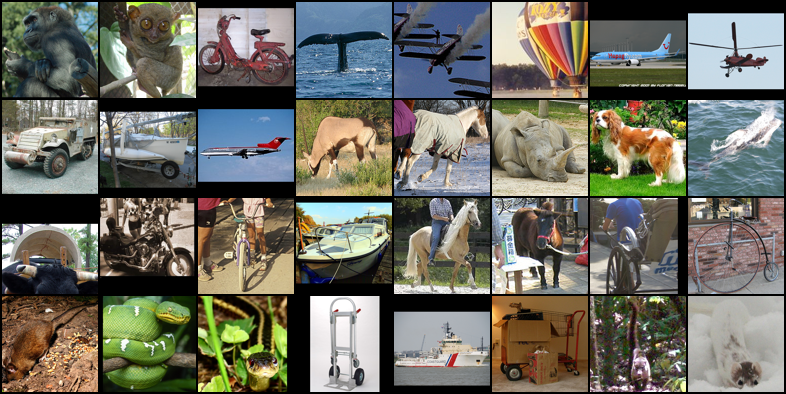

In [115]:
# dataiter = iter(unlabeledloader)
images, labels, filenames = dataiter.next() # 返回4张图片及标签

#print(' '.join('%11s'% classes[labels[j]-1] for j in range(32)))


imgs = None
for f in filenames:
    img = np.array(Image.open(f))
    if(imgs is None):
        imgs = np.concatenate([img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])
    else:
        imgs = np.concatenate([imgs, img.reshape(1, 96, 96, 3).transpose(0, 3, 1, 2)])

# 计算图片在每个类别上的分数
outputs = model(images.cuda())
# 得分最高的那个类
_, predicted = torch.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'\
            % classes[predicted[j]-1] for j in range(32)))

show(tv.utils.make_grid((torch.tensor(imgs))))

In [129]:
preds = outputs.softmax(dim=1)
preds

tensor([[1.7491e-12, 6.2862e-12, 5.1304e-10,  ..., 1.7087e-12, 1.5566e-12,
         1.6911e-12],
        [4.3494e-10, 3.4002e-08, 1.4348e-07,  ..., 4.9544e-10, 4.8883e-10,
         5.1739e-10],
        [4.1471e-11, 2.8764e-06, 3.6040e-09,  ..., 4.0990e-11, 4.0095e-11,
         5.0233e-11],
        ...,
        [5.4287e-08, 3.3431e-06, 1.9637e-04,  ..., 6.4683e-08, 5.9985e-08,
         5.7207e-08],
        [2.3368e-07, 1.2803e-05, 6.1768e-04,  ..., 2.8529e-07, 2.7245e-07,
         2.8472e-07],
        [4.4543e-07, 7.1880e-03, 7.7110e-01,  ..., 5.1009e-07, 3.6688e-07,
         4.4802e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [130]:
preds.shape

torch.Size([32, 1000])